---

## **Introduction**

### **Montecarlo Control Method in Grid World**

I implemented a code to apply **Monete carlo** in a grid world

<br>

**Policy iteration** and **Value iteration** require information about dynamics, meaning they are model-based methods. However, the **Monte Carlo method** does not require a model. By directly experiencing **trial and error**, it computes the value function or action value function and improves the policy to find the optimal policy.

To ensure exploration of all states, policy improvement was implemented by **updating the policy using the epsilon-greedy method**.


<br>

---

<br>

The grid world map is structured as follows:

- The game `starts` at the **Door** position.
- **Walls** are `impassable`.
- Passing through **Radiation** incurs a `penalty`.
- Reaching the **Treasure** position grants a `reward` and `ends the game.`

<img src="https://drive.google.com/uc?export=view&id=1UyixvvHu-hOYDmUtHK_ko5pjLUZWnAg1" alt="Gridworld" width="400">

---


In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from collections import defaultdict
from matplotlib.patches import Rectangle, Polygon

class GridWorld:
  def __init__(self, policy):
    self.policy = policy

    self.wall_map = np.array([
        ['wall',  0,     'wall',  0,     0],
        [0,       0,     0,       0,     'wall'],
        [0,       'wall', 0,      'wall', 'wall'],
        [0,       0,     0,       0,     'wall'],
        [0,       0,     0,       0,     0]])
    wall_indices = np.where(self.wall_map == 'wall')
    self.wall_cordinates = list(zip(wall_indices[0], wall_indices[1]))
    self.reward_map = np.array([
        [0, 0, 0, 0, 1],
        [-1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, -1, 0, 0, 0],
        [0, 0, 0, 0, 0]
    ])
    penalty_indices = np.where(self.reward_map < 0)
    self.penalty_cordinates = list(zip(penalty_indices[0], penalty_indices[1]))
    self.action_mean = {
        0: 'UP',
        1: 'DOWN',
        2: 'LEFT',
        3: 'RIGHT'}
    self.action_move = {
        0: (-1, 0),
        1: (+1, 0),
        2: (0, -1),
        3: (0, +1)}
    self.num_action = len(self.action_mean)
    self.action_arrows = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.Qs = defaultdict(lambda: 0)
    self.ns = defaultdict(lambda: 0)
    self.epsilon = 0.1
    self.history = []

  def montecarlo_one_epiosde(self):
    current_state = self.start_state
    self.history = []
    # 아래를 반복
    while True:
      action = self.get_action(current_state)

      next_state = self.next_state(current_state, action)
      reward = self.reward_map[next_state]
      self.history.append((current_state, action, reward))

      if next_state == self.terminal_state:
        break

      current_state = next_state

  def get_action(self, state):
    actions_list = list(self.policy[state].keys())
    probs_list = list(self.policy[state].values())
    action = np.random.choice(actions_list, p = probs_list)

    return action

  def next_state(self, current_state, action):
    (y, x) = current_state
    (dy, dx) = self.action_move[action]
    next_state = (y + dy, x + dx)
    next_state = (
        max(0, min(self.grid_limit[0], next_state[0])),
        max(0, min(self.grid_limit[1], next_state[1])))
    if next_state in self.wall_cordinates:  # If the next state is a wall, stay in the current state
      next_state = current_state
    return next_state

  def policy_update(self, state, action):
    Qs_list = []
    for action in range(self.num_action):
      self.policy[state][action] = self.epsilon / self.num_action
      Qs_list.append(self.Qs[state, action])
    max_Qs = np.max(Qs_list)
    greedy_actions = np.where(Qs_list == max_Qs)[0]
    for greedy_action in greedy_actions:
      self.policy[state][greedy_action] += (1 - self.epsilon) / len(greedy_actions)


  def render(self, policy_show=True):
    fig, ax = plt.subplots(figsize=(10, 8))
    """
    Visualize the grid world with value function and optional policy arrows
    """
    # Q-value의 최소/최대값 계산
    all_q_values = [value for value in self.Qs.values()]
    vmin = min(all_q_values) if all_q_values else 0
    vmax = max(all_q_values) if all_q_values else 1  # 기본값 설정

    # 색상 맵 설정
    colors = ["red", "white", "green"]  # 빨강-흰색-초록
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    white_cmap = LinearSegmentedColormap.from_list('white_cmap', ['darkgray', 'darkgray'])
    norm = TwoSlopeNorm(vmin=vmin, vcenter=(vmin + vmax) / 2, vmax=vmax)

    ax.pcolormesh(np.flipud(np.zeros((self.width, self.height))), cmap = white_cmap, vmin=0, alpha=0.8)

    for y in range(self.height):
      for x in range(self.width):
        if (y, x) in self.wall_cordinates:
          plt.text(
                x + 0.5, self.height - y - 0.5, "Wall",
                ha="center", va="center", fontsize=20, color="purple", fontweight = 'bold')
          continue
        elif (y, x) == self.terminal_state:
          plt.text(
              x + 0.5, self.height - y - 0.5,
              "Goal",
              ha="center", va="center", fontsize=35, color="gold", fontweight = 'bold')
          continue
        elif (y, x) in self.penalty_cordinates:
          plt.text(
              x + 0.5, self.height - y - 0.65,
              "radiation",
              ha="center", va="center", fontsize=15, color="black", fontweight = 'bold')
        tx, ty = x, self.width - y - 1
        action_map = {
            0: ((0.5 + tx, 0.5 + ty), (tx + 1, ty + 1), (tx, ty + 1)),  # Up
            1: ((tx, ty), (tx + 1, ty), (tx + 0.5, ty + 0.5)),          # Right
            2: ((tx, ty), (tx + 0.5, ty + 0.5), (tx, ty + 1)),          # Down
            3: ((0.5 + tx, 0.5 + ty), (tx + 1, ty), (tx + 1, ty + 1)),  # Left
        }
        action_values = [self.Qs[((y, x), action)] for action in range(len(self.action_mean))]
        for action, color_value in zip(action_map.keys(), action_values):
          triangle_points = action_map[action]
          color = custom_cmap(norm(color_value))
          ax.add_patch(Polygon(triangle_points, facecolor=color, alpha=0.8, edgecolor = 'black', linewidth = 0.5))
          # 삼각형 내부에 숫자 표시
          centroid_x = np.mean([p[0] for p in triangle_points])
          centroid_y = np.mean([p[1] for p in triangle_points])
          ax.text(
                centroid_x, centroid_y, f"{color_value:.2f}",
                ha="center", va="center", fontsize=10, color="black"
          )
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.gca().set_xticks(np.arange(self.width + 1), minor=True)
    plt.gca().set_yticks(np.arange(self.height + 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=0.7)
    plt.title("GridWorld Map, Montecarlo", fontsize=16)
    plt.show()


  def reset(self):
    self.start_state = (4, 0)
    self.value_map = np.zeros(shape = (5, 5))
    self.terminal_state = (0, 4)
    self.grid_limit = (self.height - 1, self.width - 1)
    self.gamma = 0.9
    self.Qs = defaultdict(lambda: 0)
    self.ns = defaultdict(lambda: 0)
    self.history = []

  @property
  def height(self):
    return self.reward_map.shape[0]

  @property
  def width(self):
    return self.reward_map.shape[1]

In [18]:
random_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
game = GridWorld(random_policy)
total_episode = 2000

for _ in range(total_episode):
  game.montecarlo_one_epiosde()
  G = 0
  for data in reversed(game.history):
    state, action, reward = data
    game.ns[state, action] += 1
    G = reward + game.gamma * G
    game.Qs[state, action] += 1/game.ns[state, action] * (G - game.Qs[state, action])

---

<br>

### **Estimating Action Values via Monte Carlo under a Random Policy**

The following result shows the action-value estimation using the **Monte Carlo method** under a **random policy** (a policy that selects all actions randomly).


<br>

---

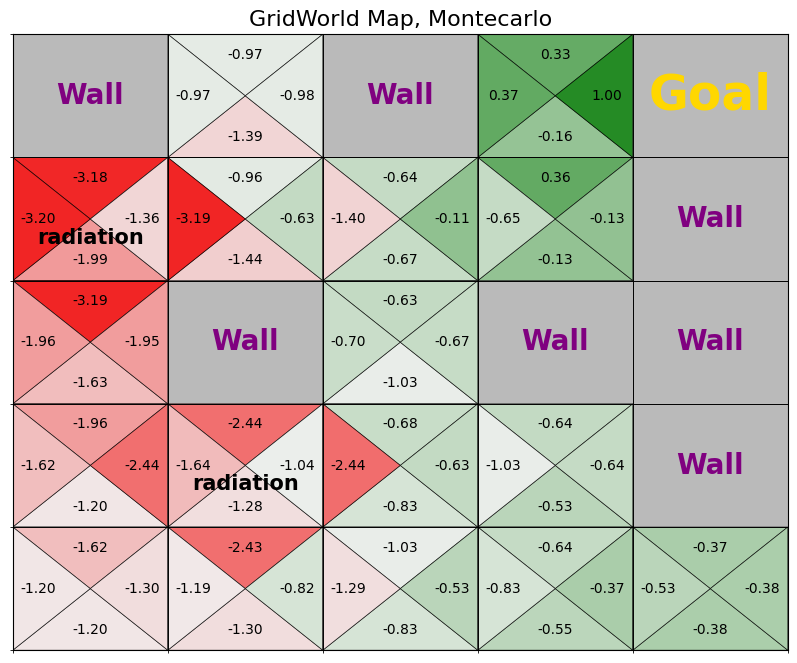

In [19]:
game.render()

---

<br>

### **Near Optimal Policy Search Using the Monte Carlo Method**

<br>

When the **policy is updated in a purely greedy manner**, no exploration occurs in subsequent episodes. To address this, the **epsilon-greedy method** is used to ensure exploration.

However, when estimating action values using the epsilon-greedy method:
- The resulting action values are **not truly optimal**, but rather reflect the action values of a **near-optimal policy**.
- This happens because the policy incorporates **probabilistic exploration**, which deviates from strictly optimal behavior.


Below is the result of performing policy updates using the epsilon-greedy method with MC.

<br>

---

### **A Key Point about Policy and Return Evaluation**

A key point is that **using an exponential moving average (EMA)** is essential to prioritize **recently experienced returns** as the policy evolves. This approach ensures a more accurate estimation of the value under the current policy.

- **Why EMA is Important**:
  - EMA assigns greater weight to recent returns while gradually diminishing the influence of older returns.
  - It dynamically adjusts to changes in the policy, ensuring value estimation stays relevant.

- **Benefit**:
  - By emphasizing recent returns, EMA allows for a more precise evaluation of the expected value, reflecting the behavior of the current policy.

- **Takeaway**: Incorporating exponential moving average helps adapt value estimations to evolving policies, ensuring more accurate and reliable results.

---

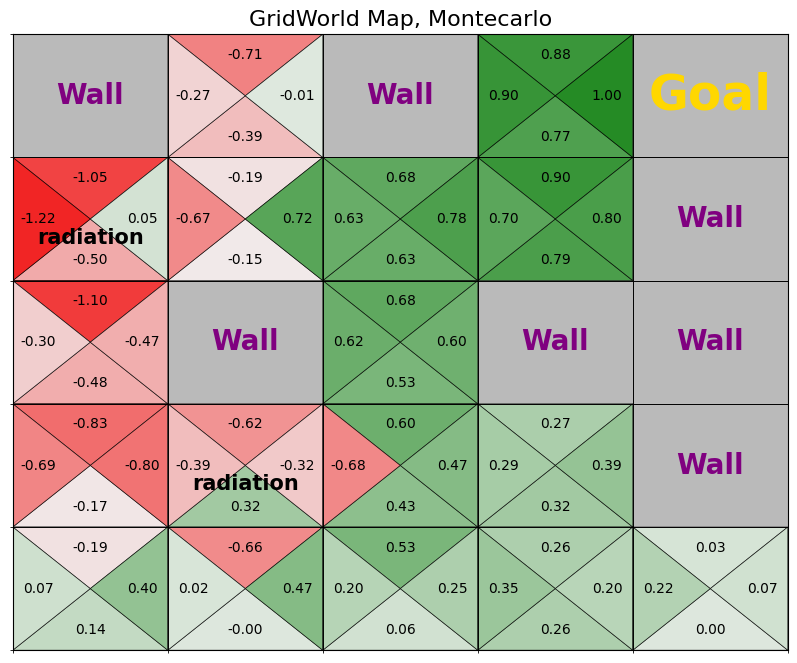

In [20]:
random_policy = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
alpha = 0.1
game2 = GridWorld(random_policy)
total_episode = 2000

for _ in range(total_episode):
    game2.montecarlo_one_epiosde()
    G = 0
    for data in reversed(game2.history):
        state, action, reward = data
        G = reward + game2.gamma * G
        game2.Qs[state, action] += alpha * (G - game2.Qs[state, action])
        game2.policy_update(state, action)

game2.render()

---

## **Conclusion**


As described above, the policy using the epsilon-greedy method **does not calculate the exact optimal action value**, nor does it represent the optimal policy. However, since it selects actions that are expected to be optimal with a high probability, the resulting values can be considered **approximations of the optimal values**.

- **Key Points**:
  - **Epsilon-Greedy Method**: Balances exploration and exploitation by occasionally choosing random actions (exploration) while mostly choosing actions with high estimated values (exploitation).
  - **Not Truly Optimal**: The approach inherently sacrifices some degree of optimality due to its exploratory nature.
  - **Near-Optimal Approximation**: Despite this, the selected actions are often close to optimal, making the resulting values approximate the optimal action values.

- **Summary**: While epsilon-greedy policies are not guaranteed to be optimal, they strike a practical balance, leading to high-probability selections of near-optimal actions and approximating over time.


<br>

---